## Jellyfish cell atlas topological analysis using `totopos`

In this notebook we will perform the `totopos` workflow on the *Clytia hemisphaerica* cell atlas from [Chari et al](https://www.science.org/doi/10.1126/sciadv.abh1683). 


*Clytia hemispherica* is a hydrozoan, and a member of the cnidarian clade. These animals have been studied for quite a long time for their capacity of whole-body regeneration. This is in part because of a very interesting stem cells that continously give rise to all major lineages in the adult animal: is like always having embryonic stem cells. This property, allows to study developmental-like differentiation pathways using adult animals.

In [1]:
%load_ext autoreload 
%autoreload 2
import anndata as ad
from ripser import ripser 
from persim import plot_diagrams
from os.path import join
from totopos import viz as tpv
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import totopos as tp

tpv.set_plotting_style_plt()

ddir = "/home/mnu/projects/topo/data/clytia/"
persdgm_dir = "/home/mnu/projects/topo/persdiags/census/"

In [2]:
fig_dir = "/home/mnu/projects/topo/figs/paper_figs/medusa"

The dataset we use in this tutorial is a processed version of the version supplied by the authors. In brief, we performed the following processing: 

* QC: removed cells with less than 1000 UMIs, and less than 500 expressed genes.
* Log-normalization.
* Highly-variable gene filtering.

In [3]:
adata = ad.read_h5ad(join(ddir, "clytia_hvg.h5ad"))

#### Doublet removal

Even though authors reported doublet removal, we'll perform doublet removal on precomputed [`scrublet`](https://github.com/swolock/scrublet) scores.

In [4]:
df_doublet_scores = pd.read_csv(join(ddir, "clytia_doublet_scores_.csv"))

In [5]:
adata.obs.rename(columns={"cellId": "cell_barcode"}, inplace=True)

In [6]:
adata.obs = pd.merge(adata.obs, df_doublet_scores, how="inner")

In [7]:
adata.obs.predicted_doublets.value_counts()

predicted_doublets
False    8945
True      108
Name: count, dtype: int64

In [8]:
a = adata[adata.obs.predicted_doublets==False].copy()

/home/mnu/miniconda/envs/gph/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


### Persistent homology (PH) analysis 

With our clean and tidy data, we're ready to perform topological loop identification using persistent homology (PH). The null hypothesis is that a developmental dataset should have a tree-like topology. Then the idea of our approach is that identifying a prominent loop would provide evidence against a tree topology. 

To identify loops, in brief, we will first compute PH on the whole dataset. Then, significant loops will be those loops whose lifetime is twice as large as those loops from small neighborhoods in data. In other words, we're using the lifetime or persistence of the loops for ranking loops.

In [9]:
%%time
topology=tp.totopos.Totopos(a,n_pcs=20,verbose=True)

Computing persistent homology...
CPU times: user 1min 26s, sys: 6.35 s, total: 1min 33s
Wall time: 1min 15s


In [10]:
# Here we will compute the lifetimes across neighborhoods of ~ 350 single-cells
nbd_size=350
thresh= topology.compute_ph_noise_floor(nbd_size=nbd_size)

Estimating PH noise floor using Voronoi neighborhoods...: 100%|█████| 25/25 [00:03<00:00,  7.89it/s]


In [11]:
# lifetimes of the first homology group
one_dgms = topology.ph["dgms"][1]
lifetimes = one_dgms[:, 1] - one_dgms[:, 0]

In [12]:
ix_sort = np.argsort(lifetimes)[::-1]

Text(0.5, 1.0, 'Jellyfish cell atlas \n persistence diagram')

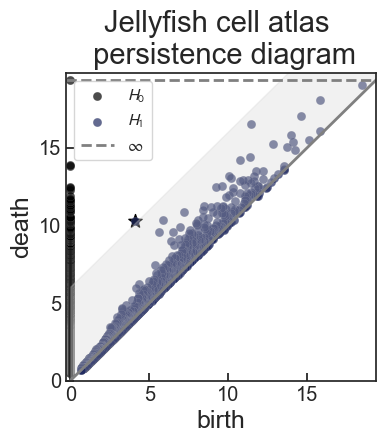

In [13]:
fig = plt.figure(figsize=(4,4))
x, y = one_dgms[ix_sort[0]]
plt.scatter(x, y, marker="*", color="black", s=100)
tpv.plot_pers_diag_ripser(topology.ph["dgms"], pal = ["#000000", "#212b61"], conf_int = 2*thresh)
plt.title("Jellyfish cell atlas \n persistence diagram")

# plt.savefig(
#     join(fig_dir, "persistence_diagram.png"), bbox_inches="tight", dpi=200
# )

# plt.savefig(
#     join(fig_dir, "persistence_diagram.pdf"), bbox_inches="tight", dpi=200
# )

### `topoCells` analysis

Now that we've found one prominent loop let's compute the topocells using the critical edge method. The topocells are defined as the cells in the neighborhood of the homology class representative.

In [14]:
n_loops = 3 # compute the top 3 most persistent loops for exploration

In [15]:
%%time
topology.compute_topocells(n_loops = 3, verbose=True)
homology_data = topology.homology_data

  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Starting VR graph construction.
Finished VR graph. Starting 1-th loop discovery...


 33%|█████████████████████▎                                          | 1/3 [01:53<03:47, 113.95s/it]

Finished computing loop 1 from VR graph.
Starting VR graph construction.
Finished VR graph. Starting 2-th loop discovery...


 67%|██████████████████████████████████████████▋                     | 2/3 [04:11<02:07, 127.96s/it]

Finished computing loop 2 from VR graph.
Starting VR graph construction.
Finished VR graph. Starting 3-th loop discovery...


100%|████████████████████████████████████████████████████████████████| 3/3 [06:12<00:00, 124.09s/it]

Finished computing loop 3 from VR graph.
Finished critical edge algorithm.
CPU times: user 6min 11s, sys: 1.03 s, total: 6min 12s
Wall time: 6min 12s


In [16]:
for i in range(n_loops):
    print(f"Cell type proportions in loop {i+1}:")
    print(a[homology_data[i]['topocell_ixs']].obs.annos.value_counts(True).head(5))
    print(f"")

Cell type proportions in loop 1:
annos
Nematocyte              0.509049
Stem Cell/Germ Cell     0.464767
Neural                  0.021563
Gastroderm              0.002310
Bioluminescent Cells    0.001925
Name: proportion, dtype: float64

Cell type proportions in loop 2:
annos
Nematocyte             0.421851
Stem Cell/Germ Cell    0.334370
Neural                 0.126750
Gastroderm             0.051711
Epidermal/Muscle       0.042185
Name: proportion, dtype: float64

Cell type proportions in loop 3:
annos
Stem Cell/Germ Cell     0.537565
Nematocyte              0.366580
Neural                  0.062608
Bioluminescent Cells    0.025043
Gastroderm              0.006477
Name: proportion, dtype: float64



In [17]:
for i in range(n_loops):
    print(f"Cell subtype proportions in loop {i+1}:")
    print(a[homology_data[i]['topocell_ixs']].obs.annosSub.value_counts(True).head(5))
    print(f"")

Cell subtype proportions in loop 1:
annosSub
i-Cells                        0.453215
Early Nematoblasts             0.154024
Differentiating Nematocytes    0.110512
Nematocyte Precursors          0.102811
Late Nematoblasts              0.075857
Name: proportion, dtype: float64

Cell subtype proportions in loop 2:
annosSub
i-Cells                                 0.240669
Early Nematoblasts                      0.087675
Differentiating Nematocytes             0.087675
Terminal Differentiating Nematocytes    0.084953
Neural Cells Early Stages               0.074650
Name: proportion, dtype: float64

Cell subtype proportions in loop 3:
annosSub
i-Cells                      0.522453
Early Nematoblasts           0.183506
Nematocyte Precursors        0.131261
Neural Cells Early Stages    0.055699
Mid Nematoblasts             0.040587
Name: proportion, dtype: float64



From looking at the cell type proportions it's clear that there's a very interesting set of loop systems in the Intersticial Stem Cell systems, relating to differentiation with nematocytes, and neural cells. Notably, **most of the cells are of the nematocyte type, a cell type we have found to form a loop in multple cnidarians**.

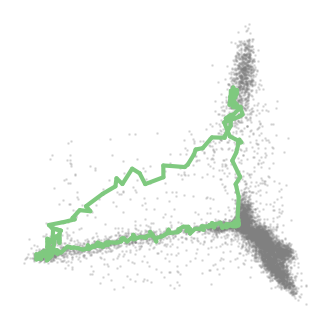

In [18]:
tpv.visualize_h1(a.obsm["pcs"][:,:2],[homology_data[0]["loop"]])

In [19]:
pal = ["#5b8188", "#a9b785", "#204d89"]

Text(0.5, 1.0, 'topoCells in jellyfish cell atlas')

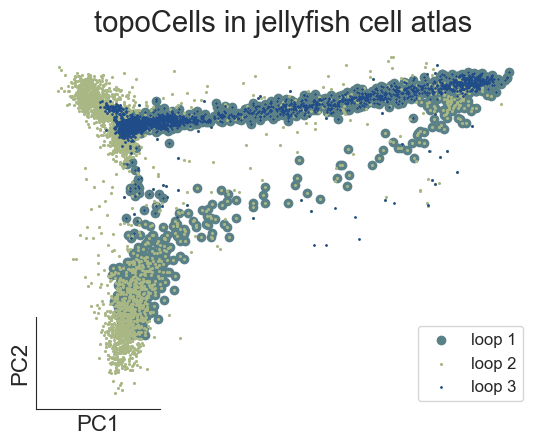

In [20]:
fig=plt.figure()
ax = fig.add_subplot()
ax.scatter(*homology_data[0]["topocells"][:,:2].T,  label = f"loop 1", color = pal[0])
ax.scatter(*homology_data[1]["topocells"][:,:2].T, s=2, marker="*", label = f"loop 2", color = pal[1])
ax.scatter(*homology_data[2]["topocells"][:,:2].T,s = 1, label = f"loop 3", color = pal[2])
ax.legend()
ax.axis("off")
inset_pc_ax = ax.inset_axes([0.00, 0.00, 0.25, 0.25])

inset_pc_ax.set_xlabel("PC1", fontsize=16)
inset_pc_ax.set_ylabel("PC2", fontsize=16)
inset_pc_ax.set_xticks([])
inset_pc_ax.set_yticks([])
# Hide top and right spines for cleaner look
inset_pc_ax.spines['top'].set_visible(False)
inset_pc_ax.spines['right'].set_visible(False)

# Optionally, emphasize bottom/left spines
inset_pc_ax.spines['left'].set_linewidth(0.8)
inset_pc_ax.spines['bottom'].set_linewidth(0.8)
inset_pc_ax.set_facecolor('none')
ax.set_title("topoCells in jellyfish cell atlas")

We can see that the loops are clearly overlapping. **Let's focus on the most persistent homology class.**

In [21]:
tpc_ada = a[homology_data[0]["topocell_ixs"]].copy()

In [22]:
subtype_counts=tpc_ada.obs.annosSub.value_counts()

In [23]:
min_cells_viz = 10
subtypes_viz = [x for x in subtype_counts.index if subtype_counts[x]>min_cells_viz]

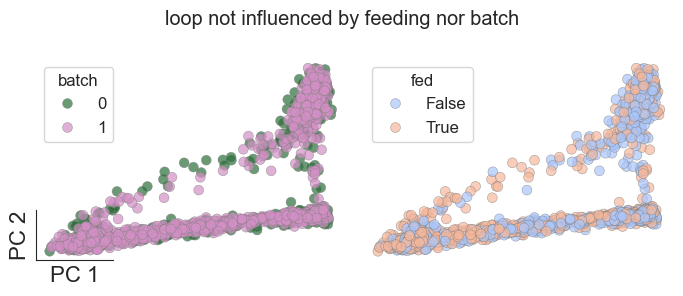

In [24]:
fig = plt.figure(figsize=(7,3))
ax = fig.add_subplot(121)
sns.scatterplot(
    tpc_ada[tpc_ada.obs.annosSub.isin(subtypes_viz)].obs, x = "pc1", y = "pc2", hue = "batch", palette = "cubehelix",
    linewidth=.4, edgecolor="grey", alpha=.7, s=50, ax = ax
)

ax.axis("off")

tpv.make_inset_axis_label(ax)

ax = fig.add_subplot(122)

sns.scatterplot(
    tpc_ada[tpc_ada.obs.annosSub.isin(subtypes_viz)].obs, x = "pc1", y = "pc2", hue = "fed", palette = "coolwarm",
    linewidth=.4, edgecolor="grey", alpha=.7, s=50, ax = ax
)
ax.axis("off")

plt.suptitle("loop not influenced by feeding nor batch")
plt.tight_layout()
# fig.savefig(
#     join(fig_dir, "condition_batch_influence_on_topoCells.png"), dpi = 200
# )

/tmp/ipykernel_378386/5357977.py:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.scatterplot(


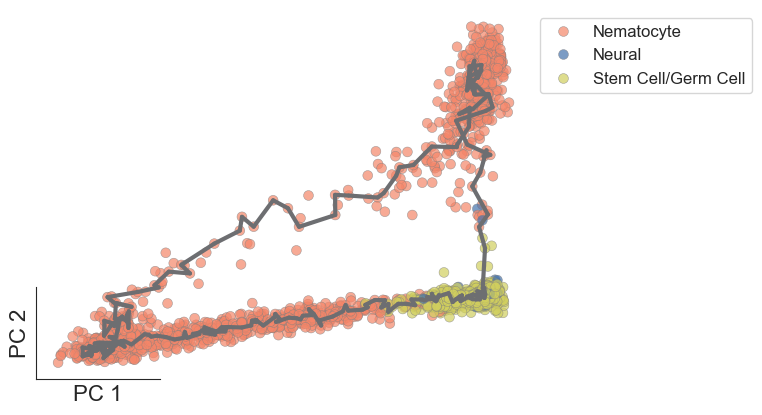

In [25]:
fig=plt.figure()
ax = fig.add_subplot()
sns.scatterplot(
    tpc_ada[tpc_ada.obs.annosSub.isin(subtypes_viz)].obs, x = "pc1", y = "pc2", hue = "annos", palette = tpv.inna_palette()[::-1], 
    linewidth=.4, edgecolor="grey", alpha=.7, s=50
)

tpv.visualize_h1(a.obsm["pcs"][:,:2],[homology_data[0]["loop"]],ax = ax,pal = ["#6d6e71"], scatter= False)

ax.axis("off")
ax.legend(bbox_to_anchor=(1,1))
tpv.make_inset_axis_label(ax)

# plt.savefig(
#     join(fig_dir, "topoCells_colored_by_cell_type.png"), bbox_inches="tight", dpi=200
# )

# plt.savefig(
#     join(fig_dir, "topoCells_colored_by_cell_type.pdf"), bbox_inches="tight", dpi=200
# )

In [26]:
pal = tpv.inna_palette()

In [27]:
pal.append("#529986")

In [28]:
from topo import viz

In [29]:
color_terminally_diff = viz.categorical_large_list()[5+len(subtypes_viz)]
color_differentiating_nematocytes = viz.categorical_large_list()[5]

/tmp/ipykernel_378386/3888196167.py:3: UserWarning: The palette list has more values (25) than needed (9), which may not be intended.
  sns.scatterplot(


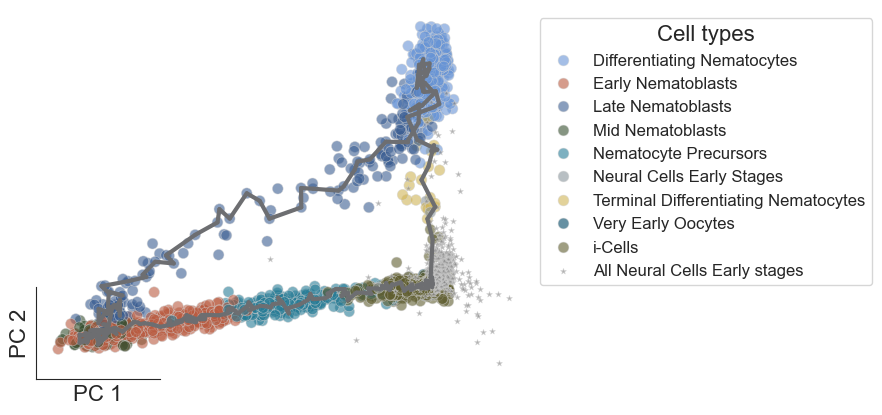

In [30]:
fig=plt.figure()
ax = fig.add_subplot()
sns.scatterplot(
    tpc_ada[
        tpc_ada.obs.annosSub.isin(subtypes_viz)    
    ].obs, x = "pc1", y = "pc2", hue = "annosSub", palette = viz.categorical_large_list()[5:],
    linewidth=.5, edgecolor="lightgrey", s = 60,
    alpha=.6
)

ax.scatter(
    *a[
        a.obs.annosSub=="Neural Cells Early Stages"
    ].obsm["pcs"][:,:2].T,
    color=  "grey",
    linewidth=.5, edgecolor="lightgrey", s = 20,
    alpha=.6, marker="*", 
    label = "All Neural Cells Early stages"
)



tpv.visualize_h1(a.obsm["pcs"][:,:2],[homology_data[0]["loop"]],ax = ax, pal = ["#6d6e71"], scatter= False)

ax.axis("off")
ax.legend(bbox_to_anchor=(1,1),title="Cell types", title_fontsize=16)
tpv.make_inset_axis_label(ax)

# plt.savefig(
#     join(fig_dir, "topoCells_colored_by_cell_subtype.png"), bbox_inches="tight", dpi=200
# )

# plt.savefig(
#     join(fig_dir, "topoCells_colored_by_cell_subtype.pdf"), bbox_inches="tight", dpi=200
# )

### `topoGenes` analysis

Now, let's infer the genes associated with the loop topology, the `topoGenes`. `topoGene` scores computation is essentially *free* once the PH diagram is computed using the perturbation method. This can be directly called using the following method:

In [31]:
%%time
topogene_scores, grads = topology.compute_topological_scores_and_gradients_perturb(ix_top_class=1)

CPU times: user 3.18 s, sys: 71.6 ms, total: 3.25 s
Wall time: 137 ms


In [32]:
tpg_isort=np.argsort(topogene_scores)[::-1]

In [33]:
n_topogenes=500

In [34]:
cly_genes = tpc_ada.var.gene_name.values

In [35]:
topogenes = cly_genes[tpg_isort[:n_topogenes]]

In [36]:
tpg_funcs=tpc_ada.var[
tpc_ada.var.gene_name.isin(topogenes)
].function.values.to_list()
tpg_funcs= np.array([x for x in tpg_funcs if x != "none"])

/tmp/ipykernel_378386/1256325034.py:3: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  ].function.values.to_list()


In [37]:
list(tpg_funcs[:10])

['LYSOSOMAL ACID LIPASE/CHOLESTERYL ESTER HYDROLASE',
 'SUBFAMILY NOT NAMED',
 'WD REPEAT-CONTAINING PROTEIN 36',
 'NUCLEOPORIN P58/P45',
 'TROPOMYOSIN-1, ISOFORMS 33/34',
 'PROTEIN TYROSINE PHOSPHATASE 4E, ISOFORM A-RELATED',
 'OLFACTORY RECEPTOR AND ADENOSINE RECEPTOR',
 'HYPHALLY REGULATED CELL WALL PROTEIN 1',
 'MITOGEN-ACTIVATED PROTEIN KINASE 15',
 'SUBFAMILY NOT NAMED']

Let's cluster the `topoGenes`. 

In [38]:
from topo.clus import oNMF

In [39]:
n_clus=5

In [40]:
tpc_by_tpg = tpc_ada[:, tpc_ada.var.gene_name.isin(topogenes)].X.A

In [41]:
%%time
E,W = oNMF(
    X=tpc_by_tpg,
    k=5,
    n_iters=500,
)

Orthogonal NMF performed with 500 iterations

CPU times: user 2min 8s, sys: 6.3 s, total: 2min 14s
Wall time: 5.62 s


In [42]:
E=np.asarray(E)
W=np.asarray(W)

In [43]:
topocell_cluster_assignment = E.argmax(1)

In [44]:
topogene_cluster_assignment = W.argmax(0)

Now, in order to display the topogene clusters, we'll use the natural manifold coordinates inferred using the circular coordinates algorithm.

In [45]:
cnidocyte_topology = tp.totopos.Totopos(tpc_ada,verbose=True) # initialize a new object to compute circular coords in smaller dset

Computing persistent homology...


In [46]:
circular_coordinates=cnidocyte_topology.circular_coordinate(n_pcs=2,ix_top_class=1)

(-26.623596489429474,
 3.4414849877357483,
 -5.971841740608215,
 18.655156540870667)

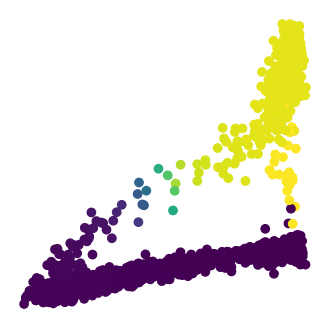

In [47]:
plt.figure(figsize=(4,4))
plt.scatter(*tpc_ada.obsm["pcs"][:, :2].T, c = circular_coordinates, cmap = "viridis")
plt.axis("off")

In [48]:
avg_coords = np.zeros(n_clus)
for i in range(n_clus): 
    avg_coords[i] = circular_coordinates[np.argwhere(topocell_cluster_assignment==i).flatten()].mean()

In [49]:
sort_clus = np.argsort(avg_coords)

In [50]:
remapping = dict(zip(np.arange(n_clus), sort_clus))

In [51]:
new_topocell_clus_assignment = np.array([remapping[x] for x in topocell_cluster_assignment])

In [52]:
cell_isort = np.argsort(new_topocell_clus_assignment)

In [53]:
new_topogene_clus_assignment = np.array([remapping[x] for x in topogene_cluster_assignment])

In [54]:
gene_isort = np.argsort(new_topogene_clus_assignment)

In [ ]:
import matplotlib.colors as mcolors

Text(64.58333333333333, 0.5, 'topoCells')

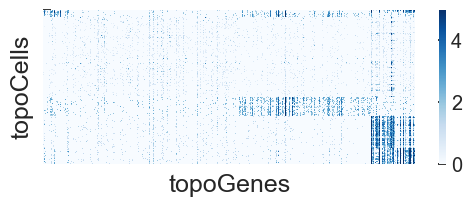

In [56]:
plt.figure(figsize=(6,2))
sns.heatmap(
    tpc_by_tpg[cell_isort][:, gene_isort],xticklabels=[""], yticklabels=[""], 
    vmax=5,
    cmap = "Blues", 
    #col_colors=[mcolors.to_rgb(pal[x]) for x in new_topogene_clus_assignment[gene_isort]],
    #row_cluster=False, 
    #col_cluster=False, 
    #figsize=(8,3)
)
# plt.xticks([""])
# plt.yticks([""])
plt.xlabel("topoGenes")
plt.ylabel("topoCells")
# plt.savefig(
#     join(fig_dir, "topocells_by_topogenes.png"), dpi = 300, bbox_inches="tight"
# )

In [58]:
for i in range(n_clus): 
    print(f"Cluster {i+1} funcs")
    ixs_clus=np.argwhere(topogene_cluster_assignment==i).flatten()
    funcs_clus = tpc_ada.var[tpc_ada.var.gene_name.isin(topogenes[ixs_clus])].function.to_list()
    funcs_clus = [x for x in funcs_clus if x != "none"]
    print(funcs_clus[:30])

    print(f"")

CLuster 1 funcs
['WD REPEAT-CONTAINING PROTEIN 36', 'TROPOMYOSIN-1, ISOFORMS 33/34', 'MITOGEN-ACTIVATED PROTEIN KINASE 15', 'CALCIUM-BINDING PROTEIN CML15-RELATED', 'CARBONIC ANHYDRASE 1', 'COLLAGEN, TYPE XXIV, ALPHA 1', 'CALMODULIN-LIKE PROTEIN 8', 'NME/NM23 FAMILY MEMBER 8', 'CHYMOTRYPSIN-RELATED', 'GAP JUNCTION DELTA-4 PROTEIN', 'WW DOMAIN-CONTAINING OXIDOREDUCTASE-LIKE PROTEIN', 'FAMILY NOT NAMED', 'COLLAGEN ALPHA-1(IV) CHAIN', 'VOLTAGE-DEPENDENT L-TYPE CALCIUM CHANNEL SUBUNIT ALPHA-1D', 'METHYLTRANSFERASE-LIKE PROTEIN 27', 'THIOREDOXIN-RELATED TRANSMEMBRANE PROTEIN 4', 'TRANSCRIPTION FACTOR SPT8', 'ESSENTIAL MCU REGULATOR, MITOCHONDRIAL', '4-AMINOBUTYRATE AMINOTRANSFERASE, MITOCHONDRIAL', 'THROMBOSPONDIN-RELATED ANONYMOUS PROTEIN', 'AQUAPORIN TRANSPORTER', 'PROTEIN CBG11750-RELATED', 'PROTEIN DISULFIDE-ISOMERASE', 'SUBFAMILY NOT NAMED', 'NEURAL PROLIFERATION DIFFERENTIATION AND CONTROL PROTEIN-1  NPDC-1 PROTEIN', 'VITELLOGENIN-RELATED', 'WAS/WASL-INTERACTING PROTEIN FAMILY MEMBER 

Text(0.5, 0.98, 'topoGene programs using oNMF')

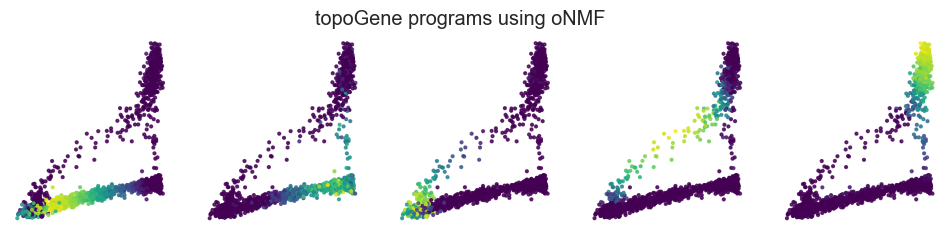

In [59]:
fig,axes=plt.subplots(1,n_clus,figsize=(12,2.5))
for i,ax in enumerate(axes.flat):
    clu = remapping[i]
    ax.scatter(*tpc_ada.obsm["pcs"][:,:2].T, c=E[:,clu], alpha=.8, cmap="viridis",s=4)
    ax.axis("off");

fig.suptitle("topoGene programs using oNMF",y=.98)
# plt.savefig(
#     join(fig_dir, "topoGenes_clustered.png"), bbox_inches="tight", dpi = 400
# )

# plt.savefig(
#     join(fig_dir, "topoGenes_clustered.pdf"), bbox_inches="tight", dpi = 400
# )

In [60]:
tpg_funcs=tpc_ada.var[
    tpc_ada.var.gene_name.isin(topogenes)
].function.values.to_list()

/tmp/ipykernel_378386/2253158209.py:3: FutureWarning: Categorical.to_list is deprecated and will be removed in a future version. Use obj.tolist() instead
  ].function.values.to_list()


#### Enrichment test

In [61]:
human_to_cly_orthologs = pd.read_csv(join(ddir, "hydra_clytia_human_orthologs.csv"))

In [62]:
topogenes_human_orthologs = human_to_cly_orthologs[human_to_cly_orthologs["clytia_gene_name"].isin(topogenes)]["human_gene_name"]

In [63]:
topogenes_human_ortho_uniq = topogenes_human_orthologs.unique()

In [64]:
import gseapy

In [65]:
df_enrichment = gseapy.enrichr(
    gene_list = list(topogenes_human_ortho_uniq), gene_sets = ["Panther_2016", "Reactome_2022"]
).results

df_enrichment = df_enrichment[df_enrichment["Adjusted P-value"]<0.05]

In [66]:
df_enrichment.shape

(31, 10)

In [67]:
df_enr_reactome= df_enrichment[df_enrichment["Gene_set"]=="Reactome_2022"].sort_values(by="Adjusted P-value")

In [68]:
df_enr_reactome["reactome_label"] = df_enr_reactome["Term"].str.split("R-HSA",expand=True)[0]

In [69]:
df_enr_reactome["-logpval"] = -np.log(df_enr_reactome["Adjusted P-value"])

/tmp/ipykernel_378386/1283123372.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


Text(0.5, 1.0, 'topoGene enrichment test')

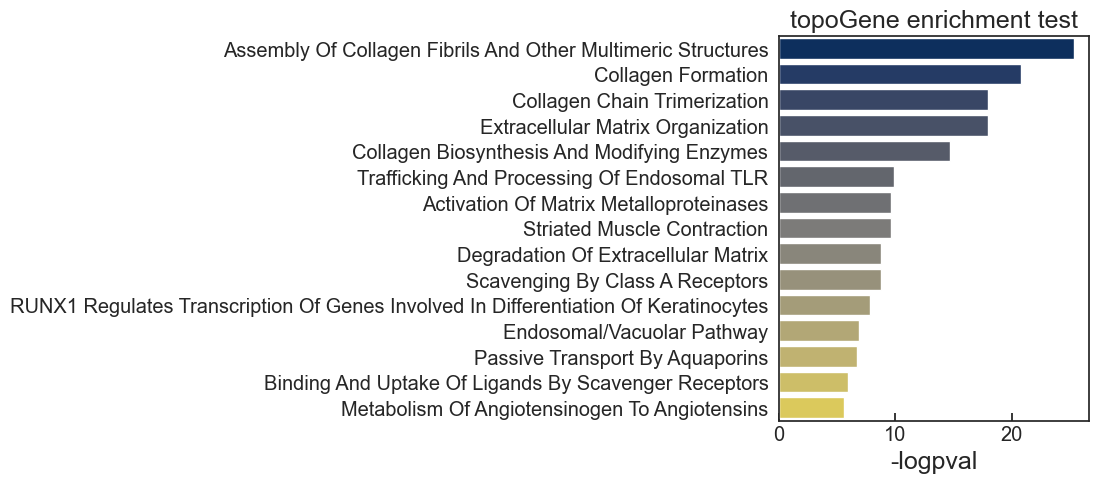

In [70]:
plt.figure(figsize=(4,5))
sns.barplot(
    data=df_enr_reactome.head(15),
    x="-logpval", 
    y = "reactome_label",
    palette = "cividis"
)
plt.ylabel("")
plt.title("topoGene enrichment test", fontsize=18)

# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.png"), dpi = 200, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.pdf"), dpi = 200, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.jpeg"), dpi = 200, bbox_inches="tight"
# )

# plt.savefig(
#     join(fig_dir, "enrichment_test_barplot.svg"), dpi = 200, bbox_inches="tight"
# )

In [72]:
import os
from google import genai
gemini_api_key = "your_api_key"
client = genai.Client(api_key=gemini_api_key)

In [73]:
from totopos import utils

In [74]:
input_gsea="--".join(
    list(df_enrichment.Term.values + "| genes: "+ df_enrichment.Genes.values)
)

In [75]:
print("\n".join(input_gsea.split("--")[:5]))

Nicotinic acetylcholine receptor signaling pathway Homo sapiens P00044| genes: MYH1;MYH7B;MYH2;MYH3;MYH15;MYH8;MYH13;MYH4;MYH6;MYH7
Cytoskeletal regulation by Rho GTPase Homo sapiens P00016| genes: MYH1;MYH7B;MYH2;MYH3;MYH8;MYH13;MYH4;MYH6;MYH7
Inflammation mediated by chemokine and cytokine signaling pathway Homo sapiens P00031| genes: MYH7B;MYH1;MYH2;MYH3;MYH13;MYH8;MYH4;MYH6;MYH7
Integrin signalling pathway Homo sapiens P00034| genes: COL1A1;COL3A1;COL1A2;COL2A1;COL4A1;COL5A2;COL4A3;COL4A5
Wnt signaling pathway Homo sapiens P00057| genes: MYH7B;MYH1;MYH2;MYH3;MYH13;MYH8;MYH4;WNT1;MYH6;MYH7


In [76]:
out = utils.summarize_gsea(input_gsea, client, n_max = 50)

In [77]:
program, genes, summary = out.split("|")

In [78]:
program, genes, summary

('Extracellular Matrix Remodeling and Muscle Contraction ',
 ' COL1A1, COL3A1, MYH7, CTSL, ELANE, AQP3 ',
 ' The terms show coordinated activity in both ECM remodeling and muscle contraction. Collagen genes (COL1A1, COL3A1) are central to ECM structure, while myosin genes (MYH7, MYH3) drive contraction. Cathepsins (CTSL) and elastase (ELANE) contribute to ECM degradation, necessary for remodeling. Aquaporins may regulate fluid balance within these tissues.\n')

#### Cell cycle test

In [79]:
s_genes = np.loadtxt(join(ddir, "clytia_s_genes.txt"), dtype=str)
m_genes = np.loadtxt(join(ddir, "clytia_g2m_genes.txt"), dtype=str)

In [80]:
from sklearn.preprocessing import StandardScaler
def get_cell_cycle_phase_from_scores(s_scores, m_scores):
    ncells=len(s_scores)
    phase = np.array(["S"]*ncells)
    cat=np.concatenate
    scores=cat((s_scores.reshape(-1,1), m_scores.reshape(-1,1)),1)
    phase[m_scores > s_scores] = "G2M"
    
    phase[np.all(scores < 0, axis=1)] = "G1" # if all scores are negative, it's G1...
    return phase

def cell_cycle_score(
    s_phase_genes, 
    m_phase_genes, 
    adata, 
    gene_col_name="gene_name"
):
    s_data = adata[:, adata.var[gene_col_name].isin(s_phase_genes)].X.A
    s_zscores = StandardScaler().fit_transform(s_data)
    s_scores = s_zscores.mean(axis=1)
    
    
    m_data = adata[:, adata.var[gene_col_name].isin(m_phase_genes)].X.A
    m_zscores = StandardScaler().fit_transform(m_data)
    m_scores = m_zscores.mean(axis=1)

    phase = get_cell_cycle_phase_from_scores(s_scores, m_scores)
    return s_scores, m_scores, phase

In [81]:
s_scores, m_scores, phase = cell_cycle_score(s_genes, m_genes, tpc_ada)

In [82]:
tpc_ada.obs["cell_cycle_phase"] = phase

/tmp/ipykernel_378386/1548003337.py:32: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  sns.scatterplot(


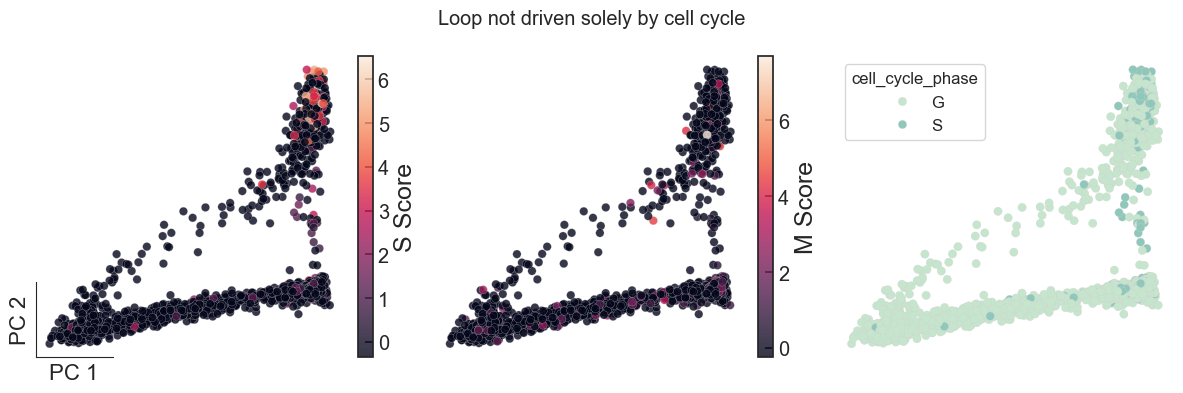

In [83]:
fig = plt.figure(figsize=(12, 4))

# First plot
ax1 = fig.add_subplot(131)
sc1 = ax1.scatter(
    *tpc_ada.obsm["pcs"][:, :2].T,
    c=s_scores,
    alpha=.8,
    linewidth=.2,
    edgecolor="lightgrey"
)
ax1.axis("off")
tpv.make_inset_axis_label(ax1)
cbar1 = fig.colorbar(sc1, ax=ax1, fraction=0.046, pad=0.04)
cbar1.set_label("S Score")

# Second plot
ax2 = fig.add_subplot(132)
sc2 = ax2.scatter(
    *tpc_ada.obsm["pcs"][:, :2].T,
    c=m_scores,
    alpha=.8,
    linewidth=.2,
    edgecolor="lightgrey"
)
ax2.axis("off")
cbar2 = fig.colorbar(sc2, ax=ax2, fraction=0.046, pad=0.04)
cbar2.set_label("M Score")

# Third plot
ax3 = fig.add_subplot(133)
sns.scatterplot(
    tpc_ada.obs,
    x="pc1",
    y="pc2",
    hue="cell_cycle_phase",
    ax=ax3,
    linewidth=.2,
    edgecolor="lightgrey",
    legend="brief", 
    palette=sns.cubehelix_palette(start=.8, rot=-.7, reverse=False, as_cmap=False)
)

ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.axis("off")

fig.suptitle("Loop not driven solely by cell cycle")
plt.tight_layout()

# plt.savefig(
#     join(fig_dir, "cell_cycle_test.png"), bbox_inches="tight", dpi=300
# )

# plt.savefig(
#     join(fig_dir, "cell_cycle_test.pdf"), bbox_inches="tight", dpi=300
# )

From the plots, the evidence points suggests that the cell cycle is not the driver of the loop.

#### Reproducibility

In [85]:
%load_ext watermark
%watermark -m -v -p scipy,numpy,torch,pandas,seaborn

Python implementation: CPython
Python version       : 3.11.8
IPython version      : 8.21.0

scipy  : 1.12.0
numpy  : 1.26.4
torch  : 2.4.1
pandas : 2.2.0
seaborn: 0.13.2

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 5.15.0-125-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 48
Architecture: 64bit

